In [135]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import os
import re
import nltk

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


# Lemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import genesis
nltk.download('genesis')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
genesis_ic = wn.ic(genesis, False, 0.0)

from nltk.tokenize import word_tokenize

# Stemmers for removing suffix, prefix etc.
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.corpus import stopwords

# Performance measures for the code
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Defining the stopwords
nltk.download('stopwords')
s = stopwords.words('english')
s.extend(['the', 'and', 'of'])

# os.chdir(r'C:\Users\Gard\Documents\Bygg- og miljøteknikk\Høst 2020\Maskinlæring\Project')

# Reading the data to be used in the classifier
data = pd.read_csv('final_data.csv', delimiter=',')

data['lyrics']=data['lyrics'].apply(str)

# Removing stopwords from dataframe
ps = nltk.wordnet.WordNetLemmatizer()
for i in range(data.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', data.loc[i,'lyrics'])
    review = review.lower()
    review = review.split()
    
    review = [ps.lemmatize(word) for word in review if not word in s]
    review = ' '.join(review)
    data.loc[i, 'lyrics'] = review
    
# Genres with high accuracy on original classification of data set
acc_genres = ['pop', 'hip hop', 'country', 'easy listening', 'latin']

# Genres that have few songs and low accuracy
bad_genres = ['christian', 'caribbean', 'folk', 'electronic', 'metal', 'jazz']


#data = data.loc[~data['genre'].isin(bad_genres)] #Remove genres with few songs and low accuracy
#data = data.loc[data['genre'] != 'pop'] #Remove pop
#data = data.loc[data['genre'].isin(acc_genres)] # Keep good genres


## Convert to Numpy
x_col = data['lyrics'].to_numpy()
y_col = data['genre'].to_numpy()

print("Below is the sample of training text after removing the stop words: \n")
print(data['lyrics'][:10])

[nltk_data] Downloading package genesis to /root/nltk_data...
[nltk_data]   Package genesis is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Below is the sample of training text after removing the stop words: 

0    yeah yeah sleeping girlfriend time youre time ...
1    one im grape street gslide sweet shay shay wou...
2    cherish two circular view blue grey shade capt...
3    change attempt good intention crouched living ...
4    ima tell ima tell right woke mornin nigga winn...
5    ye

In [136]:
# Transforming the lyrics to a tfidf dictionary
vectorizer = TfidfVectorizer(max_features=100)
tfidf_col = vectorizer.fit_transform(x_col).toarray()

# Term frequency
#vectorizer = CountVectorizer(max_features=100)
#tfidf_col = vectorizer.fit_transform(x_col).toarray()


Samples in test set:  2884
Samples in training det:  8649


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

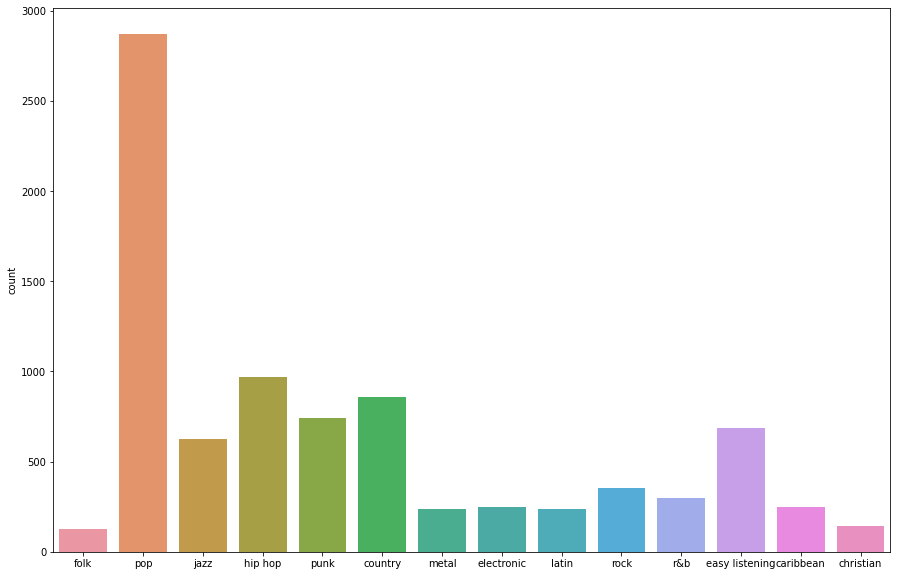

In [137]:
# Splitting into training and testing sets (75%/25%)
x_train, x_test, y_train, y_test = train_test_split(tfidf_col, y_col, test_size=0.25, random_state=0, stratify=y_col)

import seaborn as sns
fig, ax = plt.subplots(figsize=(15,10))
sns.countplot(x=y_train)

print('Samples in test set: ', len(x_test))
print('Samples in training det: ', len(x_train))

# kNN-object from scikit-learn
knn = KNeighborsClassifier(n_neighbors = 5,  weights = 'distance') # Objects with shorter distance are weighted in the classifier
knn.fit(x_train, y_train)

In [138]:
# Checking performance with built-in accuracy function

# training set
print(f'Accuracy of K-NN classifier on training set: {knn.score(x_train, y_train):.2f}')
# test set
print(f'Accuracy of K-NN classifier on test set: {knn.score(x_test, y_test):.2f}')



Accuracy of K-NN classifier on training set: 0.99
Accuracy of K-NN classifier on test set: 0.29


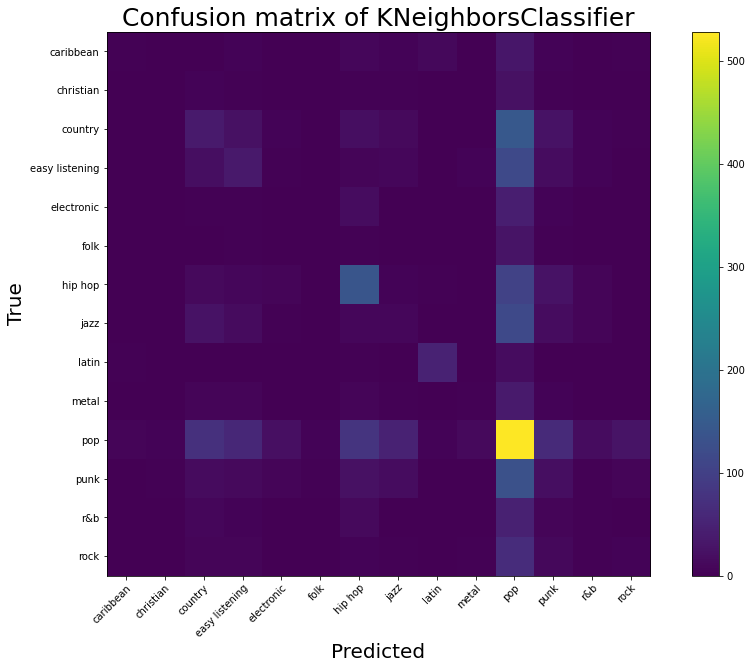

In [139]:
# Predicting from test-lyrics

genre_pred = knn.predict(x_test)
#print(genre_pred)
#print(y_test)

labels = sorted(list(set(y_col))) # Set gives a 'unique' list


# Checking performance with confusion matrix
con_mat = confusion_matrix(y_test, genre_pred, labels)

fig, ax = plt.subplots(figsize=(15,10))
cax = ax.imshow(con_mat)

plt.title('Confusion matrix of KNeighborsClassifier', fontsize=25)
fig.colorbar(cax)
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.xlabel('Predicted', fontsize=20)
plt.ylabel('True', fontsize=20)
plt.show()


In [140]:
# Accuracy of classifier
acc = np.sum(y_test == genre_pred)/len(genre_pred)
print(f'Total accuracy for test set: {acc*100:.2f} %')

# F1 score of classifier
f1 = f1_score(y_test, genre_pred, average='weighted')
print(f'Weighted F1 score of K-NN classifier on test set: {f1:.2f} \n')

# Classification report
print(classification_report(y_test, genre_pred, labels=labels))

Total accuracy for test set: 29.16 %
Weighted F1 score of K-NN classifier on test set: 0.26 

                precision    recall  f1-score   support

     caribbean       0.17      0.05      0.07        84
     christian       0.00      0.00      0.00        47
       country       0.18      0.14      0.15       286
easy listening       0.18      0.16      0.17       229
    electronic       0.02      0.01      0.01        83
          folk       0.00      0.00      0.00        42
       hip hop       0.40      0.43      0.42       323
          jazz       0.08      0.05      0.06       208
         latin       0.67      0.63      0.65        79
         metal       0.10      0.05      0.07        80
           pop       0.37      0.55      0.44       957
          punk       0.10      0.08      0.09       249
           r&b       0.07      0.04      0.05        99
          rock       0.11      0.05      0.07       118

      accuracy                           0.29      2884
     mac

In [141]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import LabelEncoder   

# kNN from scratch
class kNNscratch():
    def fit(self, x_train, y_train):
        self.x_train=x_train
        self.y_train=y_train

        # Every label gets assigned an int
        self.le = LabelEncoder()
        self.y_train_enc = self.le.fit_transform(y_train)

    
    def predict(self, x_test, k):
      # # Cosine similarity as distance measure
      dist = cosine_similarity(x_test, self.x_train)
      dist = np.where(dist==0.0, 1.0, dist) # Remove zero-values

      # # Sorting rows and obtaining indexes
      ind = np.argsort(dist, axis=1)  # Sorts each row (sim.measure for each elem. in x_text), ascendingly.
      #ind = np.fliplr(ind) # Reverse each row

      # Euclidian distance      
      #dist = euclidean_distances(x_test, self.x_train)
      #ind = np.argsort(dist, axis=1)

      neighbors = ind[:,:k]

      predictions = np.zeros(x_test.shape[0], dtype=np.int64)
      
      for i in range(neighbors.shape[0]):
        #print(neighbors[i])
        # Obtaining class for the nearest neighbors
        classes = self.y_train_enc[neighbors[i]]

        # If a tie occurs, it will choose the class with the lowest encoded value. 
        # This is due to how argmax works. bincount counts instances for each number.
        predictions[i] = np.argmax(np.bincount(classes))


      # Inverse transforming predictions to label names
      predictions = self.le.inverse_transform(predictions)

      return predictions

In [142]:
# kNN object from scratch
knn_scratch = kNNscratch()
knn_scratch.fit(x_train, y_train)

# Predicting with k neighbors
genre_scratch = knn_scratch.predict(x_test, k=5)
print('Done') #In case it takes time

Done


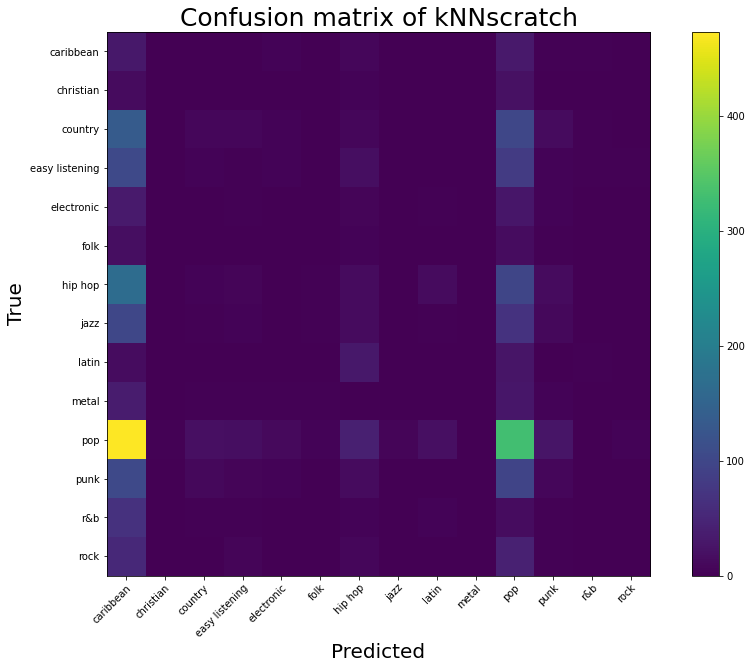

In [143]:
# Confusion matrix of predictions from kNNscratch
con_mat_scratch = confusion_matrix(y_test, genre_scratch, labels)

fig, ax = plt.subplots(figsize=(15,10))
cax = ax.imshow(con_mat_scratch)

plt.title('Confusion matrix of kNNscratch', fontsize=25)
fig.colorbar(cax)
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")



plt.xlabel('Predicted', fontsize=20)
plt.ylabel('True', fontsize=20)
plt.show()

In [144]:
# Accuracy for written kNN
acc_scratch= np.sum(y_test == genre_scratch)/len(genre_scratch)
print(f'Total accuracy for test set: {acc_scratch*100:.2f} %')

# F1 score for written kNN
f1_scratch = f1_score(y_test, genre_scratch, average='weighted')
print(f'Weighted F1 score of K-NN classifier on test set: {f1_scratch:.2f} \n')

print(classification_report(y_test, genre_scratch, labels=labels))

Total accuracy for test set: 13.77 %
Weighted F1 score of K-NN classifier on test set: 0.13 

                precision    recall  f1-score   support

     caribbean       0.02      0.37      0.04        84
     christian       0.00      0.00      0.00        47
       country       0.16      0.03      0.05       286
easy listening       0.05      0.01      0.02       229
    electronic       0.03      0.01      0.02        83
          folk       0.00      0.00      0.00        42
       hip hop       0.07      0.04      0.05       323
          jazz       0.08      0.00      0.01       208
         latin       0.00      0.00      0.00        79
         metal       0.00      0.00      0.00        80
           pop       0.33      0.34      0.34       957
          punk       0.08      0.03      0.05       249
           r&b       0.00      0.00      0.00        99
          rock       0.09      0.01      0.02       118

      accuracy                           0.14      2884
     mac

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [145]:
# Predict from single lyric (genre = hip hop)
test = ['look away cuz im stange in my mind lets make a place for me so i feel right inside lost what is gone need to know to cary on if id only see the light maybe then id be alright i know theyd rather see me down on my knees than on my feet tell me whats this world were living in sometimes it seems so strange on the outside looking in no light another man with a blood shot soul get up dont be one stand up control destiny dont back away guns are blasting hating me cant take me ive got to survive first the order the hit then forget its all justified no retreat defeat all that complete life full of tears sin for 2000 years be not afraid thats what they say im fed more lies see my violent self all has passed away but dreams stay alive test the best check pride inside minds never the enemy i aint ever going to die first youre here today and then youre gone tomorrow why must we live this way everyday wasting our lives not all has gone away i shed a tear of sorrow too bad we couldnt stay one more day follow me tonight follow me tonight lets go fly away tomorrow ehere everythings alrighty everythings alright']
test_tfidf = vectorizer.fit_transform(test).todense() 


print(knn.predict(test_tfidf))
print(knn_scratch.predict(test_tfidf, 5))

['hip hop']
['punk']


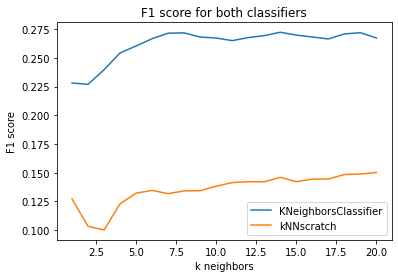

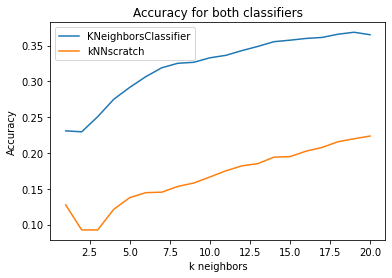

In [146]:
# Checking performance for both models with increasing amount of neighbors

# Library kNN
f1_inc = []
acc_inc = []

# Written kNN
f1_inc_own = []
acc_inc_own = []

# Max neighbor amount to check
max_neigh = 20


for i in range(1,max_neigh+1):
  knn_inc = KNeighborsClassifier(n_neighbors = i, weights = 'distance')
  knn_inc.fit(x_train, y_train)

  genre_inc = knn_inc.predict(x_test)
  acc_inc.append(np.sum(y_test == genre_inc)/len(genre_inc)) 
  f1_inc.append(f1_score(y_test, genre_inc, average='weighted'))


  genre_own = knn_scratch.predict(x_test, k=i)
  acc_inc_own.append(np.sum(y_test == genre_own)/len(genre_own)) 
  f1_inc_own.append(f1_score(y_test, genre_own, average='weighted'))


# F1 score plot
x = list(range(1, max_neigh+1))
plt.plot(x, f1_inc, label = "KNeighborsClassifier")
plt.plot(x, f1_inc_own, label = "kNNscratch")
  
plt.xlabel('k neighbors') 
plt.ylabel('F1 score') 
plt.title('F1 score for both classifiers') 

plt.legend() 
plt.show()  


# Accuracy plot
plt.plot(x, acc_inc, label = "KNeighborsClassifier")
plt.plot(x, acc_inc_own, label = "kNNscratch")
  
plt.xlabel('k neighbors') 
plt.ylabel('Accuracy') 
plt.title('Accuracy for both classifiers') 

plt.legend() 
plt.show()  